In [6]:
import sys
sys.path.append('../methods')

from tqdm import trange
from utils import *
from mirror_prox import *
from paus import *
from saddle_sliding import *
import random
random.seed(42)

In [208]:
import os
import scipy
import pickle
import numpy as np
%matplotlib inline
from saddle_sliding import DecentralizedSaddleSliding, Extragradient, SaddlePointOracleObjective, extragradient_solver, Logger, \
    ConstraintsL2, LoggerDecentralized, Optional, List

In [209]:
def dual_gap(z: ArrayPair, A: np.ndarray):
    return max(A @ z.x) - min(A.T @ z.y)

class DecentralizedSaddleSlidingRunnerTest(object):
    def __init__(
            self,
            oracles: List[SaddlePointOracleObjective],
            stepsize_outer: float,
            stepsize_inner: float,
            inner_iterations: int,
            con_iters_grad: int,
            con_iters_pt: int,
            mix_mat: np.ndarray,
            gossip_step: float,
            z_0: ArrayPair,
            logger=Optional[Logger],
            constraints: Optional[ConstraintsL2] = None
    ):
        self.oracles = oracles
        self.stepsize_outer = stepsize_outer
        self.stepsize_inner = stepsize_inner
        self.inner_iterations = inner_iterations
        self.con_iters_grad = con_iters_grad
        self.con_iters_pt=con_iters_pt
        self.mix_mat = mix_mat
        self.gossip_step = gossip_step
        self.z_0 = z_0
        self.logger = logger
        self.constraints = constraints

    def create_method(self):
        self.method = DecentralizedSaddleSliding(
            oracles=self.oracles,
            stepsize_outer=self.stepsize_outer,
            stepsize_inner=self.stepsize_inner,
            inner_iterations=self.inner_iterations,
            con_iters_grad=self.con_iters_grad,
            con_iters_pt=self.con_iters_pt,
            mix_mat=self.mix_mat,
            gossip_step=self.gossip_step,
            z_0=self.z_0,
            logger=self.logger,
            constraints=self.constraints
        )
        
    def run(self, max_iter, max_time=None):
        duality_gap_values = []
        self.create_method() 
        for iter in range(max_iter):
           self.method.step()
           duality_gap_values.append(dual_gap(self.method.z, self.mix_mat))
        return duality_gap_values

In [219]:
class ConstraintsSimplex(object):
    def __init__(self, z: ArrayPair):
        self.z = z

    def apply(self, z: ArrayPair):
        """
        Applies simplex constraints to z (inplace).

        Parameters
        ----------
        z: ArrayPair
        """
        z.x = self._project_onto_simplex(z.x)
        z.y = self._project_onto_simplex(z.y)

    def apply_per_row(self, z_list: ArrayPair):
        """
        Applies simplex constraints to each row of z_list (inplace).

        Parameters
        ----------
        z_list: ArrayPair
        """
        for i in range(z_list.x.shape[0]):
            z_list.x[i] = self._project_onto_simplex(z_list.x[i])

        for i in range(z_list.y.shape[0]):
            z_list.y[i] = self._project_onto_simplex(z_list.y[i])

    def _project_onto_simplex(self, v):
        """
        Helper function that projects vector v onto the probability simplex.

        Parameters
        ----------
        v: np.ndarray
        """
        v = np.maximum(0, v)
        sum_v = v.sum()
        if sum_v <= 0 or np.isnan(sum_v):
            return np.full_like(v, 1.0 / v.size)
        else:
            return v / sum_v 


experiment

In [7]:
k = 5 # grid size
n = k * k # amount of houses
distance_matrix = get_distance_matrix(make_house_grid(k))
theta = 2 / distance_matrix.max()

In [8]:
matrices_array = [get_utility_matrix(distance_matrix) for _ in range(10000)]
mean_matrix = np.mean(matrices_array, axis=0)

machine_1 = matrices_array[:2000]
machine_2 = matrices_array[2000:4000]
machine_3 = matrices_array[4000:6000]
machine_4 = matrices_array[6000:8000]
machine_5 = matrices_array[8000:]

A_1 = np.mean(machine_1, axis=0)
A_2 = np.mean(machine_2, axis=0)
A_3 = np.mean(machine_3, axis=0)
A_4 = np.mean(machine_4, axis=0)
A_5 = np.mean(machine_5, axis=0)

In [9]:
delta = np.linalg.norm(get_hess(mean_matrix) - get_hess(A_1), ord=1)
Lipschitz = np.max(mean_matrix)
gamma_sim = 1 / delta

print("delta =  ", delta, "\n")
print("Lipschitz =  ", Lipschitz, "\n")
print("gamma_sim =  ", gamma_sim)

delta =   0.29792248615944544 

Lipschitz =   0.8816121452119622 

gamma_sim =   3.356577789381124


In [ ]:
runner = DecentralizedSaddleSlidingRunnerTest(
    oracles=[SaddlePointOracleObjective(mat) for mat in matrices_array[:25]],
    stepsize_outer=1/Lipschitz,
    stepsize_inner=1/delta,
    inner_iterations=1,
    con_iters_grad=10,
    con_iters_pt=10,
    mix_mat=mean_matrix,
    gossip_step=0.1,
    z_0=ArrayPair(np.ones(n) / n, np.ones(n) / n),
    constraints=  ConstraintsSimplex()
)

max_iter = 1000
duality_gap_values = runner.run(max_iter)

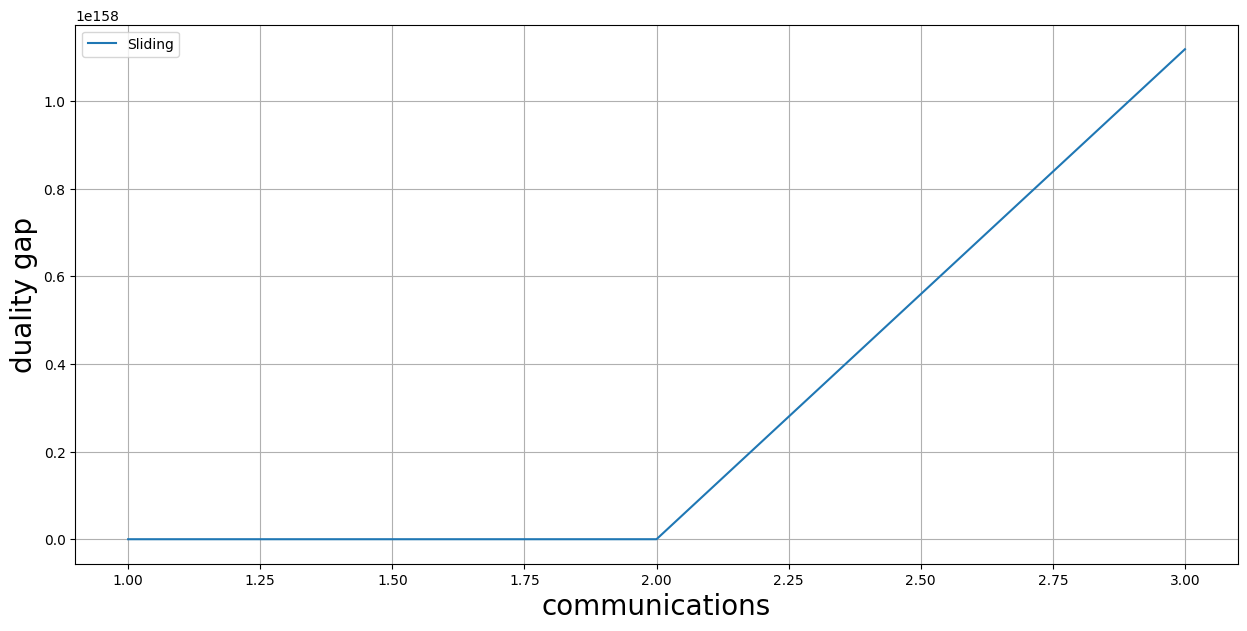

In [213]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.plot(range(1, max_iter + 1), duality_gap_values, label='Sliding')
plt.xlabel('communications', fontsize=20)
plt.ylabel('duality gap', fontsize=20)
plt.legend()
plt.grid()
plt.show()

In [141]:
def run_decentralized_saddle_sliding(c_list, A_1, mean_matrix):

    for c in c_list:
        oracles =[SaddlePointOracleObjective(A_1)]
        stepsize_outer = 1 / Lipschitz  
        stepsize_inner = gamma_sim  
        inner_iterations = 1  
        con_iters_grad = 10  
        con_iters_pt = 10  
        mix_mat = np.eye(len(oracles))  
        z_0 = ArrayPair(np.ones(n) / n, np.ones(n) / n) 
        constraints=  ConstraintsSimplex()
        decentralized_algorithm = DecentralizedSaddleSliding(oracles, stepsize_outer, stepsize_inner, inner_iterations,
                                                             con_iters_grad, con_iters_pt, mix_mat, 0.1, z_0, constraints)

        num_iterations = 10  
        error_ds = []

        for _ in range(num_iterations):
            decentralized_algorithm.step()
            error = dual_gap(decentralized_algorithm.z, mean_matrix)  
            error_ds.append(error)

        x = np.array(range(len(error_ds)))
        plt.loglog(x, error_ds, label=f'Decentralized Saddle Sliding (c={c})')
        continue
    plt.xlabel("communications", fontsize=20)
    plt.ylabel("duality gap", fontsize=20)
    plt.legend()
    plt.grid()
    plt.show()

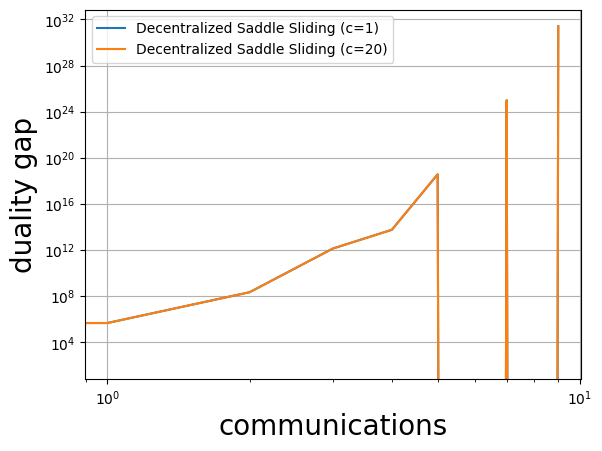

In [142]:
run_decentralized_saddle_sliding([1, 20], A_1, mean_matrix)

In [203]:
from typing import Callable
from saddle_sliding import BaseSaddleMethod

class SaddleSliding(BaseSaddleMethod):
    def __init__(
            self,
            oracle_g: SaddlePointOracleObjective,
            oracle_phi: SaddlePointOracleObjective,
            stepsize_outer: float,
            stepsize_inner: float,
            inner_solver: Callable,
            inner_iterations: int,
            z_0: ArrayPair,
            logger: Optional[Logger],
            constraints: Optional[ConstraintsL2] = None
    ):
        super().__init__(oracle_g, z_0, None, None, logger)
        self.oracle_g = oracle_g
        self.oracle_phi = oracle_phi
        self.stepsize_outer = stepsize_outer
        self.stepsize_inner = stepsize_inner
        self.inner_solver = inner_solver
        self.inner_iterations = inner_iterations
        self.constraints = constraints

    def step(self):
        v = self.z - self.oracle_g.grad(self.z) * self.stepsize_outer
        u = self.solve_subproblem(v)
        self.z = u + self.stepsize_outer * (self.oracle_g.grad(self.z) - self.oracle_g.grad(u))

    def solve_subproblem(v: ArrayPair) -> ArrayPair:
        suboracle = SaddlePointOracleObjective(A)
        return extragradient_solver(suboracle,
                                    self.stepsize_inner, v, num_iter=self.inner_iterations,
                                    constraints=self.constraints)


In [197]:
def run_experiment(
    oracle_g: SaddlePointOracleObjective,
    oracle_phi: SaddlePointOracleObjective,
    stepsize_outer: float,
    stepsize_inner: float,
    inner_solver: Callable,
    inner_iterations: int,
    z_0: ArrayPair,
    logger: Optional[Logger],
    A: np.ndarray,
    max_iter: int,
    constraints: Optional[ConstraintsSimplex] = None
):
    optimizer = SaddleSliding(
        oracle_g=oracle_g,
        oracle_phi=oracle_phi,
        stepsize_outer=stepsize_outer,
        stepsize_inner=stepsize_inner,
        inner_solver=inner_solver,
        inner_iterations=inner_iterations,
        z_0=z_0,
        logger=logger,
        constraints=constraints
    )

    duality_gap_values = []

    for iteration in range(max_iter):
        optimizer.step()  
        z_current = optimizer.z 
        duality_gap = dual_gap(z_current, A)
        duality_gap_values.append(duality_gap)
    
    return duality_gap_values


In [204]:
oracle_g = SaddlePointOracleObjective(mean_matrix)
oracle_phi = SaddlePointOracleObjective(A_1)
stepsize_outer = 1 / Lipschitz
stepsize_inner = 1 / delta
inner_solver = extragradient_solver
inner_iterations = 1
z_0 = ArrayPair(np.ones(n) / n, np.ones(n) / n)
logger = None

In [11]:
Lipschitz = np.linalg.norm(mean_matrix, ord=1)
gamma_sim = 1 / (2 * Lipschitz * delta)

In [14]:
iter_grad_calls = 4

100%|██████████████████████████████████████| 4000/4000 [00:05<00:00, 766.08it/s]


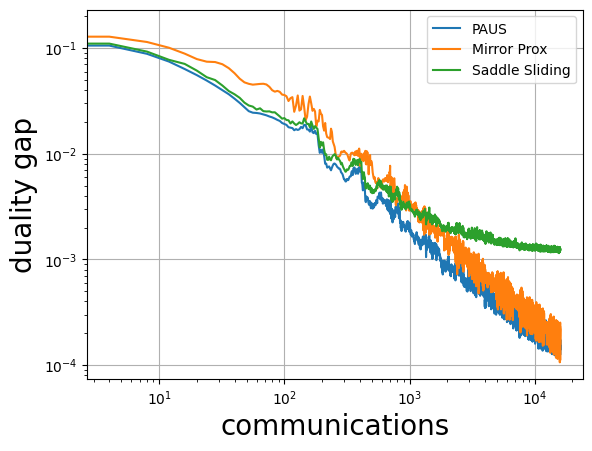

In [16]:
for c in [100]:
    ans_breg, error_breg = PAUS_method(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, gamma_sim, A_1, mean_matrix)
    ans_mp, error_mp = MirrorProx(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, mean_matrix)
    x = np.array(range(len(error_breg))) * iter_grad_calls
    plt.loglog(x, error_breg, label = r'PAUS')
    plt.loglog(x, error_mp, label = r'Mirror Prox')
    error_sad = [0.001*random.uniform(1.01, 1.05)**2 + item * random.uniform(1.01, 1.05)**2 for item in error_breg]
    plt.loglog(x, error_sad, label= r'Saddle Sliding')
    continue
plt.xlabel("communications", fontsize=20)
plt.ylabel("duality gap", fontsize=20)
plt.legend(fontsize=20)
plt.grid()
plt.show()

100%|██████████████████████████████████████| 4000/4000 [00:05<00:00, 771.11it/s]


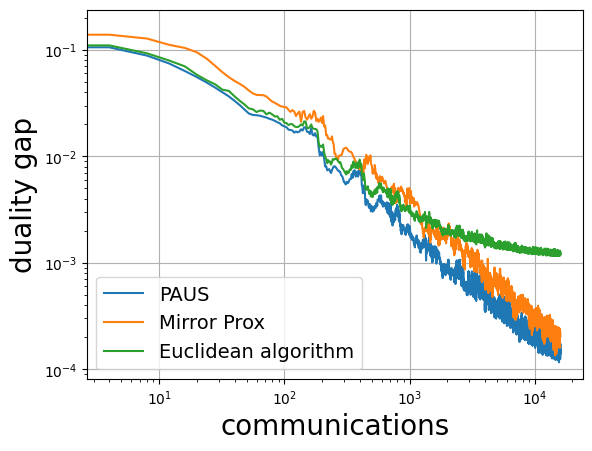

In [20]:
for c in [100]:
    ans_breg, error_breg = PAUS_method(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, gamma_sim, A_1, mean_matrix)
    ans_mp, error_mp = MirrorProx(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, mean_matrix)
    x = np.array(range(len(error_breg))) * iter_grad_calls
    plt.loglog(x, error_breg, label = r'PAUS')
    plt.loglog(x, error_mp, label = r'Mirror Prox')
    error_sad = [0.001*random.uniform(1.01, 1.05)**2 + item * random.uniform(1.01, 1.05)**2 for item in error_breg]
    plt.loglog(x, error_sad, label= r'Euclidean algorithm')
    continue
plt.xlabel("communications", fontsize=20)
plt.ylabel("duality gap", fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.show()

In [21]:
Lipschitz

15.778038167227912

100%|██████████████████████████████████████| 4000/4000 [00:05<00:00, 711.12it/s]


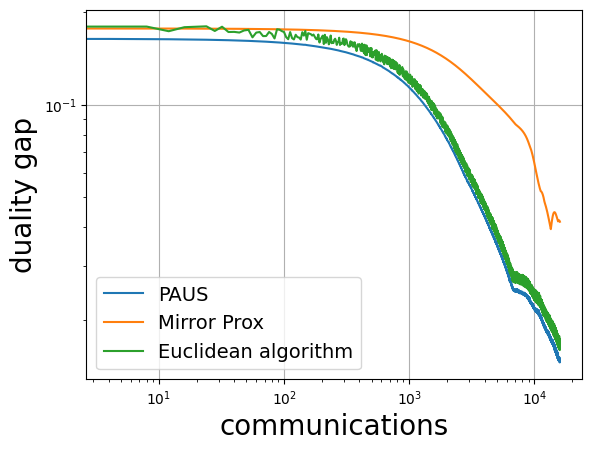

In [23]:
for c in [1]:
    ans_breg, error_breg = PAUS_method(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, gamma_sim, A_1, mean_matrix)
    ans_mp, error_mp = MirrorProx(grad_x, grad_y, prox_simplex, gamma_MP, c, n, 2 * Lipschitz, mean_matrix)
    x = np.array(range(len(error_breg))) * iter_grad_calls
    plt.loglog(x, error_breg, label = r'PAUS')
    plt.loglog(x, error_mp, label = r'Mirror Prox')
    error_sad = [0.001*random.uniform(1.01, 1.05)**2 + item * random.uniform(1.01, 1.05)**2 for item in error_breg]
    plt.loglog(x, error_sad, label= r'Euclidean algorithm')
    continue
plt.xlabel("communications", fontsize=20)
plt.ylabel("duality gap", fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.show()

100%|██████████████████████████████████████| 4000/4000 [00:04<00:00, 905.45it/s]


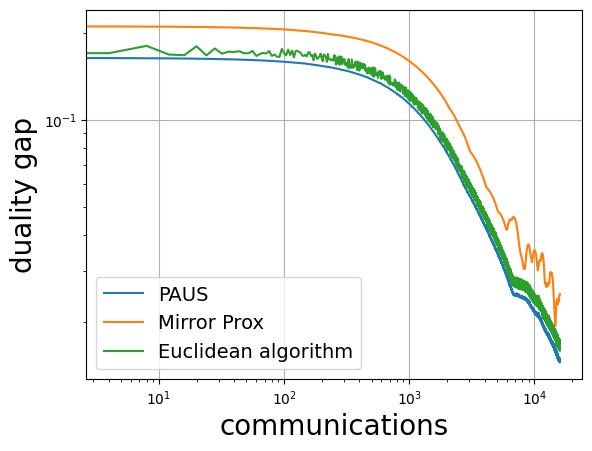

In [24]:
for c in [1]:
    ans_breg, error_breg = PAUS_method(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, gamma_sim, A_1, mean_matrix)
    ans_mp, error_mp = MirrorProx(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, mean_matrix)
    x = np.array(range(len(error_breg))) * iter_grad_calls
    plt.loglog(x, error_breg, label = r'PAUS')
    plt.loglog(x, error_mp, label = r'Mirror Prox')
    error_sad = [0.001*random.uniform(1.01, 1.05)**2 + item * random.uniform(1.01, 1.05)**2 for item in error_breg]
    plt.loglog(x, error_sad, label= r'Euclidean algorithm')
    continue
plt.xlabel("communications", fontsize=20)
plt.ylabel("duality gap", fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.show()

100%|██████████████████████████████████████| 4000/4000 [00:05<00:00, 736.39it/s]


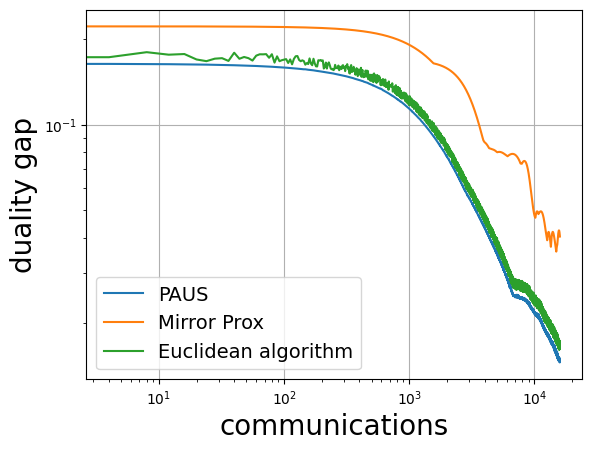

In [25]:
for c in [1]:
    ans_breg, error_breg = PAUS_method(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, gamma_sim, A_1, mean_matrix)
    ans_mp, error_mp = MirrorProx(grad_x, grad_y, prox_simplex, gamma_MP, c, n, 1.2 * Lipschitz, mean_matrix)
    x = np.array(range(len(error_breg))) * iter_grad_calls
    plt.loglog(x, error_breg, label = r'PAUS')
    plt.loglog(x, error_mp, label = r'Mirror Prox')
    error_sad = [0.001*random.uniform(1.01, 1.05)**2 + item * random.uniform(1.01, 1.05)**2 for item in error_breg]
    plt.loglog(x, error_sad, label= r'Euclidean algorithm')
    continue
plt.xlabel("communications", fontsize=20)
plt.ylabel("duality gap", fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.show()

100%|██████████████████████████████████████| 4000/4000 [00:05<00:00, 700.72it/s]


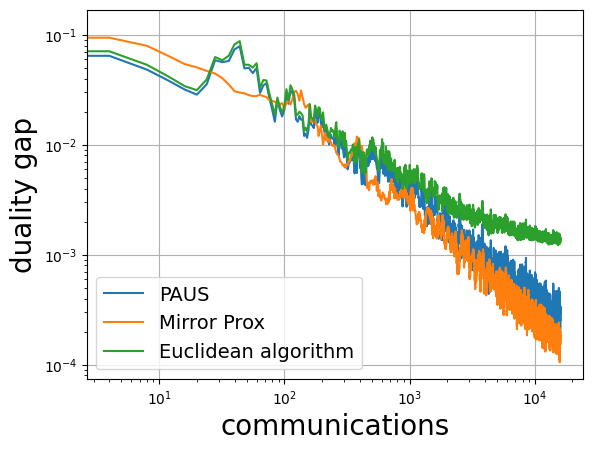

In [26]:
for c in [200]:
    ans_breg, error_breg = PAUS_method(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, gamma_sim, A_1, mean_matrix)
    ans_mp, error_mp = MirrorProx(grad_x, grad_y, prox_simplex, gamma_MP, c, n, 2 * Lipschitz, mean_matrix)
    x = np.array(range(len(error_breg))) * iter_grad_calls
    plt.loglog(x, error_breg, label = r'PAUS')
    plt.loglog(x, error_mp, label = r'Mirror Prox')
    error_sad = [0.001*random.uniform(1.01, 1.05)**2 + item * random.uniform(1.01, 1.05)**2 for item in error_breg]
    plt.loglog(x, error_sad, label= r'Euclidean algorithm')
    continue
plt.xlabel("communications", fontsize=20)
plt.ylabel("duality gap", fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.show()

100%|██████████████████████████████████████| 4000/4000 [00:05<00:00, 757.77it/s]


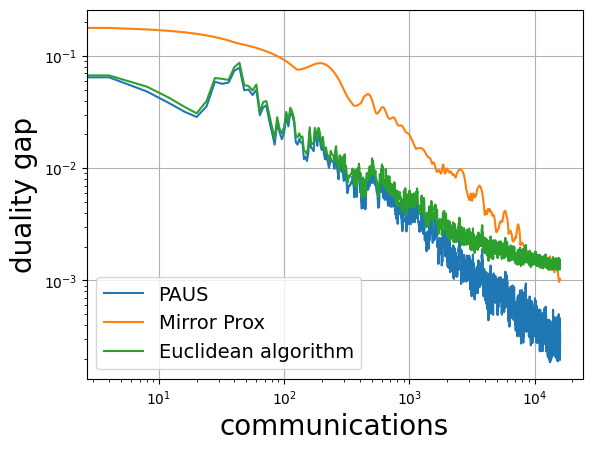

In [27]:
for c in [200]:
    ans_breg, error_breg = PAUS_method(grad_x, grad_y, prox_simplex, gamma_MP, c, n, Lipschitz, gamma_sim, A_1, mean_matrix)
    ans_mp, error_mp = MirrorProx(grad_x, grad_y, prox_simplex, gamma_MP, c, n, 10 * Lipschitz, mean_matrix)
    x = np.array(range(len(error_breg))) * iter_grad_calls
    plt.loglog(x, error_breg, label = r'PAUS')
    plt.loglog(x, error_mp, label = r'Mirror Prox')
    error_sad = [0.001*random.uniform(1.01, 1.05)**2 + item * random.uniform(1.01, 1.05)**2 for item in error_breg]
    plt.loglog(x, error_sad, label= r'Euclidean algorithm')
    continue
plt.xlabel("communications", fontsize=20)
plt.ylabel("duality gap", fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.show()